# Kaggle

Нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

Разобраем одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,2,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


<Axes: title={'center': 'Pearson Correlation of Features'}>

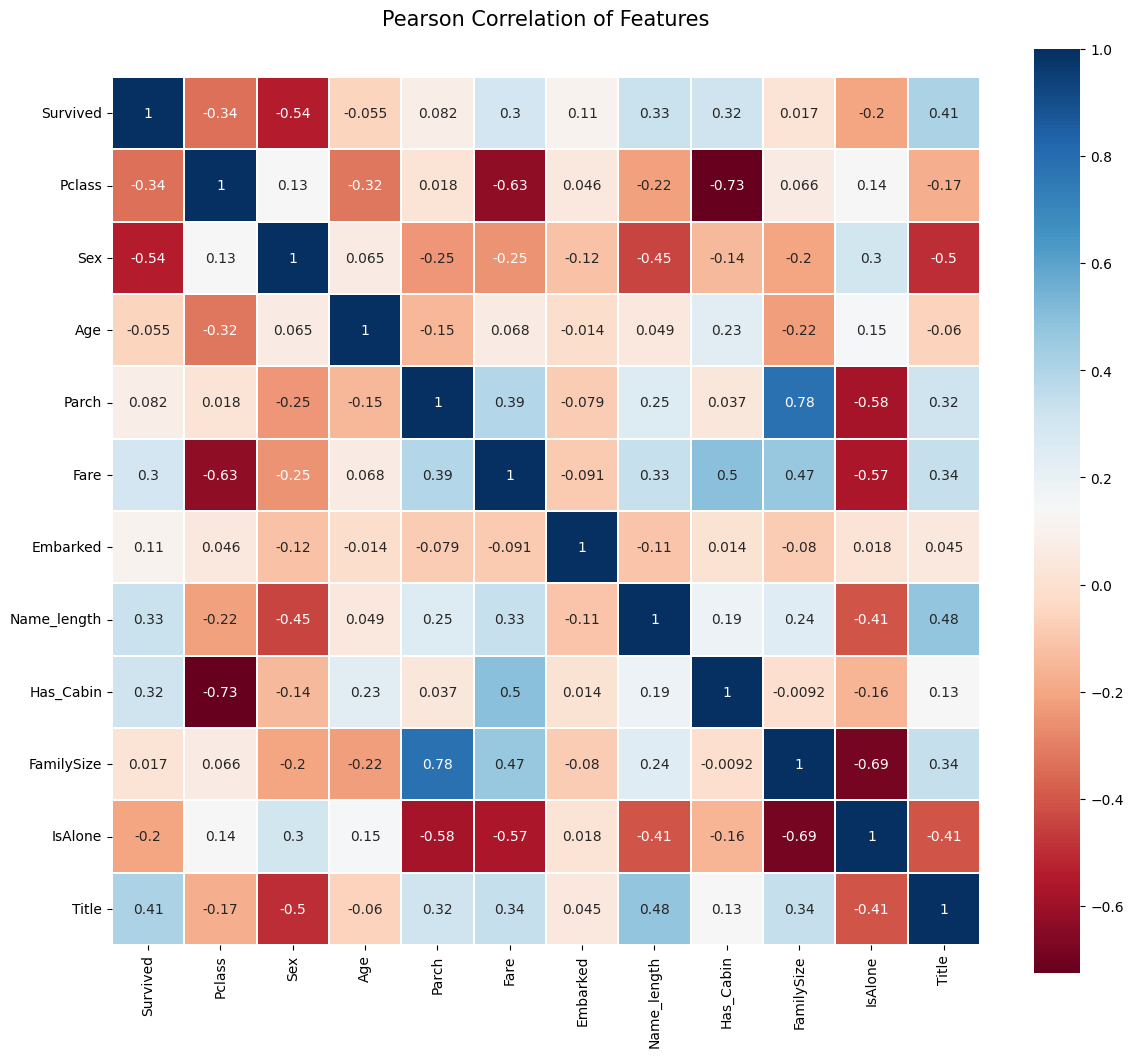

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

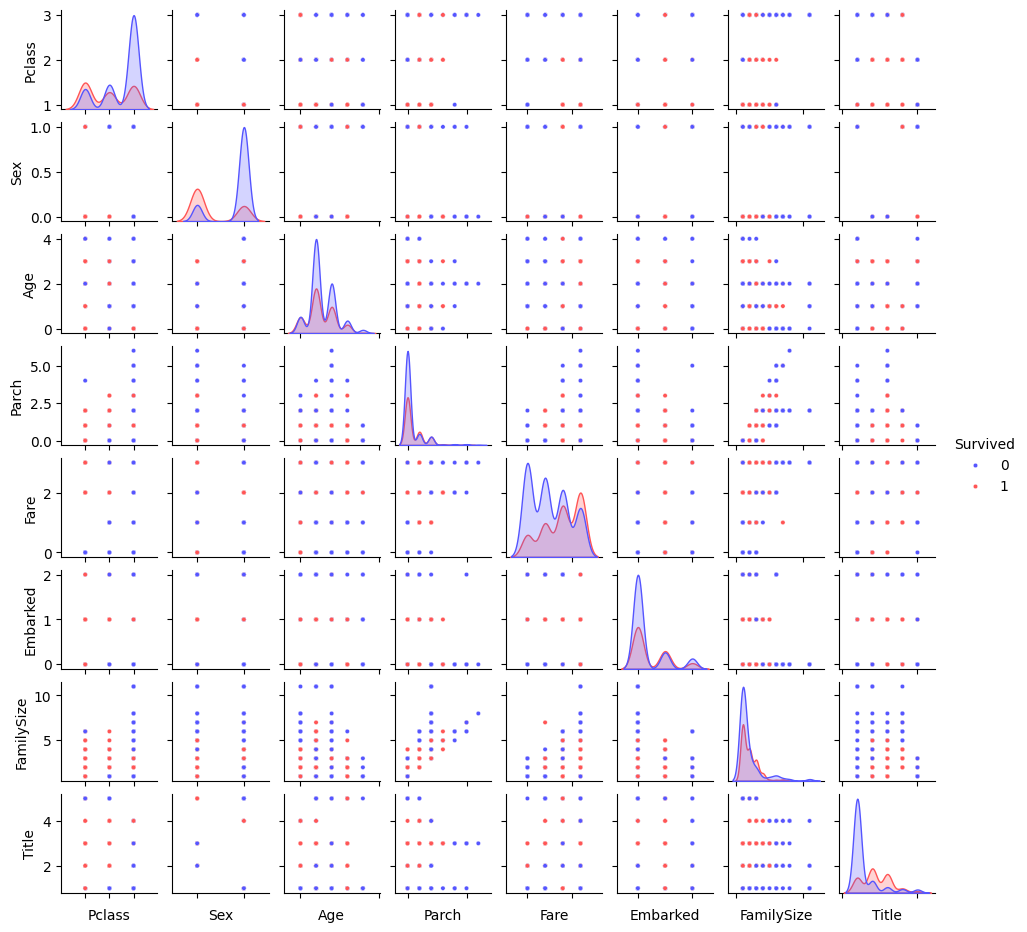

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Используем алгоритмом стекинга. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [8]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

#skf = StratifiedKFold(n_splits=5, random_state=17)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)


### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведим лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.


In [9]:
# ваш код
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier


# Разделяем данные на тренировочную и валидационную выборки
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=17)

# Параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)}  # GradientBoostingClassifier
rfc_params = {'n_estimators': range(10, 100, 10), 'min_samples_leaf': range(1, 5)}  # RandomForestClassifier
svc_params = {'kernel': ['linear', 'rbf'], 'C': np.arange(0.1, 1, 0.2)}  # SVC
lr_params = {'C': np.arange(0.5, 1, 0.1)}  # LogisticRegression

# Устанавливаем shuffle=True
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

# Определяем GridSearchCV для каждого алгоритма
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)

gbc_grid = GridSearchCV(gbc, gbc_params, cv=skf)
rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf)
svc_grid = GridSearchCV(svc, svc_params, cv=skf)
lr_grid = GridSearchCV(lr, lr_params, cv=skf)

# Обучаем каждый из объектов на тренировочной выборке
gbc_grid.fit(X_train, y_train)
rfc_grid.fit(X_train, y_train)
svc_grid.fit(X_train, y_train)
lr_grid.fit(X_train, y_train)

# Выводим лучшее сочетание параметров для каждого алгоритма
print("Лучшие параметры для GradientBoostingClassifier:", gbc_grid.best_params_)
print("Лучшие параметры для RandomForestClassifier:", rfc_grid.best_params_)
print("Лучшие параметры для SVC:", svc_grid.best_params_)
print("Лучшие параметры для LogisticRegression:", lr_grid.best_params_)

# Получаем предсказания на валидационных данных
gbc_pred = gbc_grid.predict(X_val)
rfc_pred = rfc_grid.predict(X_val)
svc_pred = svc_grid.predict(X_val)
lr_pred = lr_grid.predict(X_val)

# Вычисляем метрику качества (accuracy)
print("Accuracy для GradientBoostingClassifier:", accuracy_score(y_val, gbc_pred))
print("Accuracy для RandomForestClassifier:", accuracy_score(y_val, rfc_pred))
print("Accuracy для SVC:", accuracy_score(y_val, svc_pred))
print("Accuracy для LogisticRegression:", accuracy_score(y_val, lr_pred))

# Стекинг
base_learners = [
    ('gbc', gbc_grid.best_estimator_),
    ('rfc', rfc_grid.best_estimator_),
    ('svc', svc_grid.best_estimator_),
    ('lr', lr_grid.best_estimator_)
]

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=XGBClassifier(random_state=17))
stacking_model.fit(X_train, y_train)

# Предсказания на валидационных данных
stacking_pred = stacking_model.predict(X_val)

# Вычисляем метрику качества для стекинга
print("Accuracy для StackingClassifier:", accuracy_score(y_val, stacking_pred))



Лучшие параметры для GradientBoostingClassifier: {'learning_rate': np.float64(0.1)}
Лучшие параметры для RandomForestClassifier: {'min_samples_leaf': 4, 'n_estimators': 10}
Лучшие параметры для SVC: {'C': np.float64(0.30000000000000004), 'kernel': 'linear'}
Лучшие параметры для LogisticRegression: {'C': np.float64(0.5)}
Accuracy для GradientBoostingClassifier: 0.7761194029850746
Accuracy для RandomForestClassifier: 0.7985074626865671
Accuracy для SVC: 0.7873134328358209
Accuracy для LogisticRegression: 0.8022388059701493
Accuracy для StackingClassifier: 0.7723880597014925


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [10]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [11]:
# Создаем матрицу мета-признаков
meta_features = pd.DataFrame({
    'gbc': gbc_pred,
    'rfc': rfc_pred,
    'svc': svc_pred,
    'lr': lr_pred
})

# Определяем целевую переменную
y_meta = y_val

# Определяем параметры для XGBoost
xgb_params = {
    'n_estimators': range(10, 100, 5),
    'eta': np.arange(0.1, 1., 0.1),
    'min_child_weight': range(1, 10, 1),
    'subsample': np.arange(0.1, 1., 0.2)
}

# Устанавливаем 5-кратную кросс-валидацию
skf_meta = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Определяем XGBoost и GridSearchCV
xgb_model = XGBClassifier(random_state=17)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=skf_meta)

# Обучаем мета-алгоритм
xgb_grid.fit(meta_features, y_meta)

# Выводим лучшие параметры
print("Лучшие параметры для XGBoost:", xgb_grid.best_params_)


Лучшие параметры для XGBoost: {'eta': np.float64(0.4), 'min_child_weight': 2, 'n_estimators': 50, 'subsample': np.float64(0.1)}


### 4.
На основе алгоритма  стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [12]:
# ваш код
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score




def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5, metrics=None):
    if metrics is None:
        metrics = []  # Устанавливаем значение по умолчанию для metrics

    if test_size is None:
        # Если test_size не задан, используем весь тренировочный набор
        meta_mtrx = np.zeros((data_train.shape[0], len(models)))

        for i, model in enumerate(models):
            # Используем GridSearchCV только если параметры не None
            if isinstance(model, tuple):
                model_name, model_instance = model
                param_grid = grid_search[i] if grid_search is not None else None
                if param_grid is not None:
                    model_instance = GridSearchCV(model_instance, param_grid, cv=cv)
            else:
                model_instance = model

            meta_mtrx[:, i] = cross_val_predict(model_instance, data_train, targets_train, cv=cv, method='predict')
            model_instance.fit(data_train, targets_train)

        meta_alg.fit(meta_mtrx, targets_train)

        meta_mtrx_test = np.zeros((data_test.shape[0], len(models)))

        for i, model in enumerate(models):
            if isinstance(model, tuple):
                model_name, model_instance = model
                param_grid = grid_search[i] if grid_search is not None else None
                if param_grid is not None:
                    model_instance = GridSearchCV(model_instance, param_grid, cv=cv)
                    model_instance.fit(data_train, targets_train)  # Обучаем модель с GridSearch
            else:
                model_instance = model
            
            meta_mtrx_test[:, i] = model_instance.predict(data_test)

        meta_predictions = meta_alg.predict(meta_mtrx_test)

        # Вычисляем и выводим метрики, если переданы целевые значения
        if targets_test is not None:
            if 'roc_auc' in metrics:
                score = roc_auc_score(targets_test, meta_predictions)
                print(f'ROC AUC Score: {score:.4f}')
        
        return meta_predictions

    elif test_size > 0 and test_size < 1:
        data_train, data_val, targets_train, targets_val = train_test_split(data_train, targets_train, test_size=test_size, random_state=random_state)

        meta_mtrx = np.zeros((data_train.shape[0], len(models)))

        for i, model in enumerate(models):
            if isinstance(model, tuple):
                model_name, model_instance = model
                param_grid = grid_search[i] if grid_search is not None else None
                if param_grid is not None:
                    model_instance = GridSearchCV(model_instance, param_grid, cv=cv)
            else:
                model_instance = model

            meta_mtrx[:, i] = cross_val_predict(model_instance, data_train, targets_train, cv=cv, method='predict')
            model_instance.fit(data_train, targets_train)

        meta_alg.fit(meta_mtrx, targets_train)

        meta_mtrx_test = np.zeros((data_val.shape[0], len(models)))

        for i, model in enumerate(models):
            if isinstance(model, tuple):
                model_name, model_instance = model
                param_grid = grid_search[i] if grid_search is not None else None
                if param_grid is not None:
                    model_instance = GridSearchCV(model_instance, param_grid, cv=cv)
                    model_instance.fit(data_train, targets_train)  # Обучаем модель с GridSearch
            else:
                model_instance = model
            
            meta_mtrx_test[:, i] = model_instance.predict(data_val)

        meta_predictions = meta_alg.predict(meta_mtrx_test)

        # Вычисляем и выводим метрики, если переданы целевые значения
        if targets_val is not None:
            if 'roc_auc' in metrics:
                score = roc_auc_score(targets_val, meta_predictions)
                print(f'ROC AUC Score: {score:.4f}')
        
        return meta_predictions

    else:
        raise ValueError("test_size must be between 0 and 1")

# Определяем целевую переменную и признаки
X = train.drop('Survived', axis=1)
y = train['Survived']

# Определяем модели с наилучшими параметрами
gbc = GradientBoostingClassifier(learning_rate=0.3, random_state=17)
rfc = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, random_state=17)
svc = SVC(C=0.1, kernel='linear', random_state=17)
lr = LogisticRegression(C=0.6, random_state=17)

# Мета-алгоритм с лучшими параметрами
meta_alg = XGBClassifier(eta=0.3, min_child_weight=1, n_estimators=60, subsample=0.5, random_state=17)
# Мета-алгоритм с лучшими параметрами
#meta_alg = XGBClassifier(n_estimators=40,    eta=0.4,    min_child_weight=2,    subsample=0.3,    random_state=17)

# Список базовых моделей
models = [gbc, rfc, svc, lr]

# Параметры для GridSearchCV (если нужно)
grid_search = [None] * len(models)  # Параметры не нужны, так как мы уже используем лучшие параметры

# Используем функцию stacking для обучения и предсказания
meta_predictions = stacking(models, meta_alg, X, y, test, metrics=['roc_auc'])

# Выводим предсказания на тестовом наборе
print("Предсказания на тестовом наборе:", meta_predictions)




Предсказания на тестовом наборе: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [43]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [48]:


# Вызов функции с вашими предсказаниями и PassengerId из тестового набора
write_to_submission_file(meta_predictions, PassengerId)


In [53]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,1,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


In [54]:
test.head(10)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3
5,3,1,0,0,1,0,26,0,1,1,1
6,3,0,1,0,0,2,20,0,1,1,2
7,2,1,1,1,2,0,28,0,3,0,1
8,3,0,1,0,0,1,41,0,1,1,3
9,3,1,1,0,2,0,23,0,3,0,1


In [60]:
# ваш код
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Определяем целевую переменную и признаки
X = train.drop('Survived', axis=1)
y = train['Survived']


# Мета-алгоритм с лучшими параметрами
#предыдущее meta_alg = XGBClassifier(eta=0.3, min_child_weight=1, n_estimators=60, subsample=0.5, random_state=17)
meta_alg = XGBClassifier(eta=0.4, min_child_weight=2, n_estimators=40, subsample=0.3, random_state=17)

# Список базовых моделей
models = [gbc, rfc, svc, lr]

# Функция для записи в файл посылки
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerId', 'Survived']):
    predicted_df = pd.DataFrame({
        'PassengerId': PassengerID,
        'Survived': predictions
    })
    predicted_df.to_csv(out_file, index=False)

# Получаем предсказания на тестовом наборе
meta_predictions = stacking(models, meta_alg, X, y, test)


# Создаем идентификаторы пассажиров, начиная с 1000
PassengerId = range(892, 892 + len(test))

# Записываем предсказания в файл
write_to_submission_file(meta_predictions, PassengerId, out_file='Submission.csv')

# Выводим сообщение о завершении
print("Файл посылки успешно создан: Submission.csv")


Файл посылки успешно создан: Submission.csv


### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: 0.76315
   место 12164